# Homework 5: Neural Networks (100 points)

In this homework, you will be implementing a fully connected neural network and a convolutional neural network using the PyTorch framework.

Carlos Figueroa. Cdf5579. November 20th of 2022.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

## Load the Dataset (MNIST)

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Plotting Data

You must sample 10 images (one from each class) from the dataset and plot them as a grid with 2 rows of 5 columns each (i.e. of shape `2 x 5`).

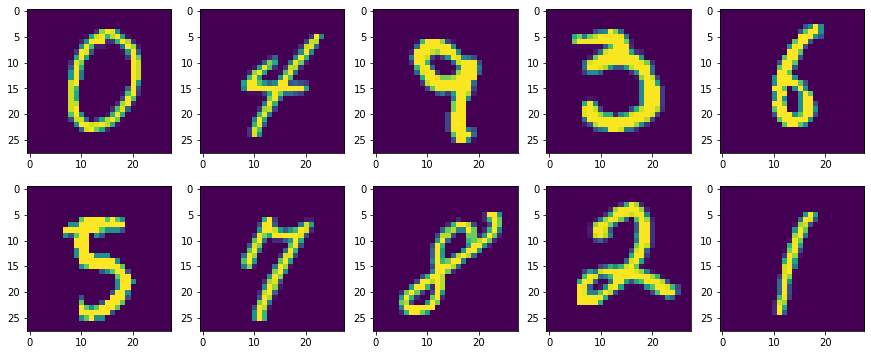

In [ ]:
# TODO: Plot 10 images with one image from each class in the training set
sampled = set()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
loc = 0
i,j = 0,0

for x, y in train_loader:
  if len(sampled) > 9:
    break
  if y[0].item() in sampled:
    continue
  sampled.add(y[0].item())
  axes[i,j].imshow(x[0].squeeze())
  if j < 4:
    j+=1
  else:
    j = 0
    i += 1

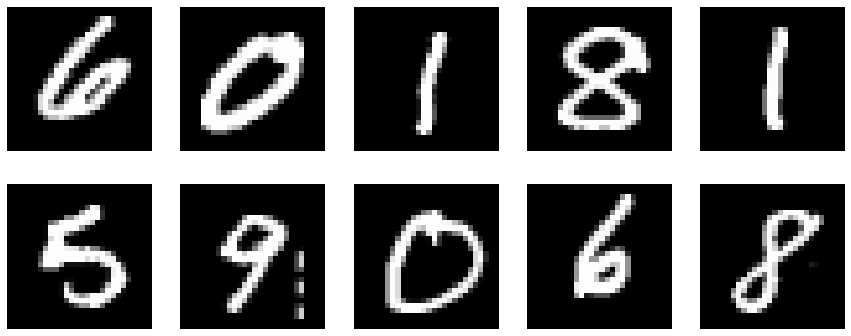

In [ ]:
figure = plt.figure(figsize=(15, 6))
cols, rows = 5, 2

for i in range(1, cols * rows + 1):
    
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()

## Train a Fully Connected Neural Network on MNIST

### Define the network

Build a 3-layer fully connected neural network that takes an input of size `784`, outputs `10` classes and has a hidden layer of size `(8,8)`. Use ReLU non-linearity and apply a logSoftmax function on the final layer.

The model must have the following architecture:

```
linear_layer(input_size, n_hidden)
relu
linear_layer(n_hidden, n_hidden)
relu
linear_layer(n_hidden, output_size)
log_softmax
```

In [ ]:
class FCN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCN, self).__init__()

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, output_size)

    def forward(self, x):

        #we always first flatten
        x = self.flatten(x)
        #linear 1 then relu and so on until softmax at the end
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x))

### Define train and test function

Complete the function for training and evaluating the model. You must use the cross entropy loss function for training the model.

Note:
- `permute` is a function passed as an argument to train and test functions.
- `permutation_order` is a 1D torch array of size 784 (=28*28). It contains the random order for permutating the pixels in the `28x28` images.

In [ ]:
def train(epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
          #keep it in gpu
          permutation_order = permutation_order.to(device)
          #use the permute_pixels function for each picture in the dataset
          for i in range(len(data)):
            data[i] = permute_pixels(data[i], permutation_order)

            
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, permute_pixels=None, permutation_order=None):
    """
    Test the model

    Args:
        model (nn.Module): model to test
        permute (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
          #keep it in gpu
          permutation_order = permutation_order.to(device)
          #use the permute_pixels function for each picture in the dataset
          for i in range(len(data)):
            data[i] = permute_pixels(data[i], permutation_order)

        output = model(data)
        test_loss += F.cross_entropy(output, target).item() # sum up batch loss                                                               
        pred = output.argmax(1)  # get the index of the max log-probability                                                                 
        correct += (target == pred).type(torch.float).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy

# Write a function for computing the total parameter count of the model

In [ ]:
# function to count number of parameters
def get_n_params(model):
    # return number of parameters in model
    num_parameters = sum(p.numel() for p in model.parameters())
    return num_parameters
    

### Train a small fully-connected network

Optimizer : SGD with lr=0.01 and momentum=0.5

In [ ]:
n_hidden = 8 # number of hidden units

model_fcn = FCN(input_size, n_hidden, output_size)
model_fcn.to(device)
optimizer = optim.SGD(model_fcn.parameters(), lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fcn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_fcn, optimizer)
    test_accuracy.append(test(model_fcn))

Number of parameters: 6442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.354736
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.993412
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.308360
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.953963
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.961311
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.674439
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.865388
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.429125
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.333581
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.650621

Test set: Average loss: 0.0005, Accuracy: 8605.0/10000 (86%)



## Train a Convolutional Neural Network (CNN) on MNIST

Define a convolutional neural network with the following architecture to classify the MNIST images.

```
Conv(
    conv2D(input_size, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
    conv2d(conv_feature, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
)

FC(
    linear_feature(conv_feature*4*4, fc_feature),
    relu(),
    linear_feature(fc_feature, output_size),
    log_softmax()
)
```

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        #we define the nets we will use
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=conv_feature, kernel_size=50) #[12,224,224]-->[72,174,174], stride default value is 1
        self.pool = nn.MaxPool2d(kernel_size=20,stride=14), #20*20 shape of kernel, stride Default value is kernel_size.[72,174,174]--->[72,12,12]
        self.conv2 = nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=5), #[72,12,12]--->[72,8,8]
        self.flatten = nn.Flatten()
        self.dropout = nn.nn.Dropout(0.2)
        self.dropout1 = nn.nn.Dropout(0.3)
        self.fc1 = nn.Linear(conv_feature*4*4, fc_feature)
        self.fc2 = nn.Linear(fc_feature, output_size)
        
    def forward(self, x):
        #here we are doing a convolution 2d, then relu, then maxpool2d per line
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        #linear, then relu
        x = F.relu(self.fc1(x))
        #finally second linear and log softmax
        return F.log_softmax(self.fc2(x))


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()

        #first do convolutional layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=conv_feature, kernel_size=50), #[12,224,224]-->[72,174,174], stride default value is 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=20,stride=14), #20*20 shape of kernel, stride Default value is kernel_size.[72,174,174]--->[72,12,12]
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=5), #[72,12,12]--->[72,8,8]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #[72,8,8]-->[72,4,4]
            )
        
        #then linear layers
        self.linear_layers=nn.Sequential(
            nn.Linear(conv_feature*4*4, fc_feature),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(fc_feature, output_size))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        result = self.linear_layers(x)
        return result

### Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
input_channels = 1
fc_features = 50

model_cnn = CNN(input_channels, conv_features, fc_features, output_size) # create CNN model
#details of this CNN are included in the class above, just copy and paste the class with parameters to initiallize
model_cnn.to(device)
#same optimizer as before
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test_accuracy.append(test(model_cnn))

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.221354
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.568497
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.273516
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.274483
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.242287
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.208365
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.276488
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.371831
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.075273

Test set: Average loss: 0.0001, Accuracy: 9610.0/10000 (96%)



### Question: Why do you think the ConvNet performs better than the fully connected network even though both have the same number of parameters?


As we discussed in class, convolutions are not densely connected, meaning that not all input nodes affect all output nodes. This gives convolutional layers more flexibility in learning, because its able to place the requiered importance in certain regions of the data with particular features. Moreover, the number of weights per layer is a lot smaller, which helps a lot with high-dimensional inputs such as image data.

Notwithstanding, this depends on the data that we are analyzing, and given that its numbers in imagenes, its better to use a convolutional network that weights inputs differently depending on their importance overall, since having the same weights (as it is in the FCN), will put equal weights on unimportant regions as well, consequently decreasing accuracy (as we saw).


### What happens if the assumptions are no longer true?

In [ ]:
# Given a permutation order, permute the pixels of the input image
def permute_pixels(data, permutation_order):
    """
    Permute the pixels of the input image
    
    Args:
        data (torch tensor): batch of input images of shape (B, 1, H, W) where B is the batch size, H is the height and W is the width.
        permutation_order (1D torch array): order of the permutation
    
    Returns:
        permuted_data (torch tensor): permuted batch of input images of shape (B, 1, H, W)
    """

    data = torch.flatten(data)

    #this torch function can perform this action for a single image
    data = torch.index_select(data, 0, permutation_order)
    #that is why when we call it in the train and test section, it is looping over the images in the training and test set


    return torch.reshape(data, (28, 28))

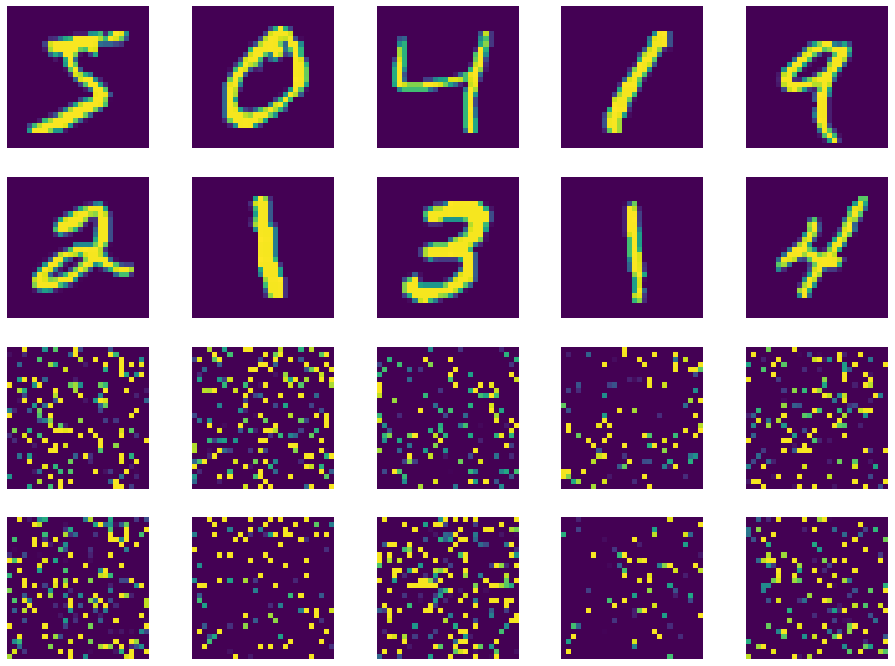

In [ ]:
permutation_order = torch.randperm(28*28)

plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    #clarification from campuswire
    image = image[None, :]
    # permute pixels
    image_perm = permute_pixels(image.clone(), permutation_order)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

    permutation_order = torch.randperm(28*28)


In [ ]:
image.clone().dim()

3

### ConvNet with permuted pixels

Train and evaluate a ConvNet with permuted pixels.

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
#this is key!
input_size = 1
fc_features = 50

model_cnn = CNN(input_size, conv_features, fc_features, output_size) # create CNN model
#same that we applied before

model_cnn.to(device)
#same optimization as before
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, permute_pixels, permutation_order)
    test(model_cnn, permute_pixels, permutation_order)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326984


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.266909
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.195266
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.944830
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.326799
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.347674
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.708905
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.655133
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.659184
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.580733

Test set: Average loss: 0.0006, Accuracy: 7914.0/10000 (79%)



### Fully-Connected with Permuted Pixels

Train and evaluate a fully connected network with permuted pixels.

In [ ]:
n_hidden = 8    # number of hidden units

model_fcn = FCN(input_size, n_hidden, output_size) # create FCN model
model_fcn.to(device)
optimizer = optim.SGD(model_fcn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fcn)))

for epoch in range(0, 1):
    train(epoch, model_fcn, optimizer, permute_pixels, permutation_order)
    test(model_fcn, permute_pixels, permutation_order)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.431341
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.029024
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.726314
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.792565
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.596496
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.637490
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.516469
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.367625
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.334639

Test set: Average loss: 0.0004, Accuracy: 8732.0/10000 (87%)



### Question: We observe that the ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same. Provide an explanation for this.



In the convNet we look at pixel posistion relative to other pixels in order to measure the importance of certain regions, and change the weights consequently (to skip unimportant regions of the data). Specifically, in the maxpool we combine nearby pixels with each other in order to gain this edge that makes convolutional networks useful. 

However, when the order of pixels is changed (meaning our assumption about the homogeneity of the data is no longer true), the performance goes down because the desicions that we are taking on the weights for certain regions are now innacurate due to the permutation of the data. 

On the other hand, in the FCN we don't have any feature like this(maxpool). As we mentioned before, everything has the same weight using FCN, so the ordering of the pixels does not matter, or would not create a direction bias as it does in the convolutional network. That is the reason why this accuracy does not change.
